In [2]:
## . . Import the plotting and libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import *
from numba import jit, njit, stencil, prange
from time import time
import multiprocessing as mp
from multiprocessing import Pool

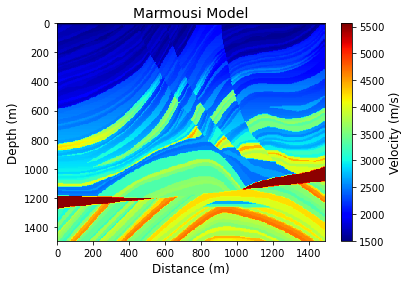

In [2]:
model= np.load('marmousi.npy')
nz,nx = 300,298
dz,dx = 5.0,5.0
oz,ox = 0.0,0.0
z = np.linspace(0,(nz-1)*dz,nz)
x = np.linspace(0,(nx-1)*dx,nx)

plt.figure()
plt.pcolormesh(x,z,model,cmap="jet",shading='auto')
plt.ylim(z.max(),z.min())
plt.xlabel('Distance (m)',fontsize=12)
plt.ylabel('Depth (m)',fontsize=12)
plt.title('Marmousi Model',fontsize=14)
cb = plt.colorbar()
cb.set_label('Velocity (m/s)',fontsize=12)

plt.show()

In [28]:
@njit(parallel=True)
def awe_2d_explicit_solver_heterogeneous_8th_order(UUo,UUm,dx,dy,dt,v,F,it,sx,sy):
    '''Set up eight-order solver of the acoustic wave equation
    usage: U=awe_2d_explicit_solver_heterogeneous_8th_order(UUo,UUm,dx,dy,dt,v,F,it,sx,sy):
    input: 
        UUo: Acoustic pressure vector (nx,ny) at time step n
        UUm: Acoustic pressure vector (nx,ny) at time step n-1
        dx : Spatial sampling in x
        dy : Spatial sampling in y        
        dt : Temporal sampling
        v  : Heterogeneous propagation velocity (nx,ny)
        F  : Forcing function (nt)
        it : Time index
        sx : Location of source in x (meters)
        sy : Location of source in y (meters)
    output:
        UUm: Acoustic pressure vector (nx,ny) at time n+1
    dependencies:
        None
    written by Jeff Shragge, jshragge@mines.edu, 10/2019
    '''        
    ## . . Get dimensions of wavefield
    nx = len(UUo[:, 0])
    ny = len(UUo[0, :])
    
    ## . . Define Courant numbers (squared)
    dtdx2,dtdy2 = (dt/dx)**2,(dt/dy)**2
        
    ## Source location
    isx,isy = int(sx/dx),int(sy/dy) ## . . Force to be integer
 
    ## . . Inject wavelet
    UUo[isx,isy] += dt*dt*F[it]

    ## . . Update solution 
    UUm[4:nx-4,4:ny-4] =  2*UUo[4:nx-4,4:ny-4]-UUm[4:nx-4,4:ny-4]+dtdx2*v[4:nx-4,4:ny-4]**2*( 
                    -1/560 *UUo[0:nx-8,4:ny-4] 
                    +8/315 *UUo[1:nx-7,4:ny-4]  
                    -1/5   *UUo[2:nx-6,4:ny-4]  
                    +8/5   *UUo[3:nx-5,4:ny-4]  
                    -205/72*UUo[4:nx-4,4:ny-4]  
                    +8/5   *UUo[5:nx-3,4:ny-4]  
                    -1/5   *UUo[6:nx-2,4:ny-4]  
                    +8/315 *UUo[7:nx-1,4:ny-4]  
                    -1/560 *UUo[8:nx  ,4:ny-4])+dtdy2*v[4:nx-4,4:ny-4]**2*( 
                    -1/560 *UUo[4:nx-4,0:ny-8] 
                    +8/315 *UUo[4:nx-4,1:ny-7]  
                    -1/5   *UUo[4:nx-4,2:ny-6]  
                    +8/5   *UUo[4:nx-4,3:ny-5]  
                    -205/72*UUo[4:nx-4,4:ny-4]  
                    +8/5   *UUo[4:nx-4,5:ny-3]  
                    -1/5   *UUo[4:nx-4,6:ny-2]  
                    +8/315 *UUo[4:nx-4,7:ny-1]  
                    -1/560 *UUo[4:nx-4,8:ny  ])

    return UUm ## . . Return updated wavefield at time step n+1

In [32]:
## . . Init wavefields on spatial grid
UUo = np.zeros((nz,nx))
UUm = np.zeros((nz,nx))

## Time stepping parameters
CC = 0.5                     # . . Courant #
nt = 4800                    # . . Number of time steps
dt = CC*dx/np.max(model)         # . . Define dt based on Courant
t  = np.linspace(0,nt*dt,nt) # . . Time lin
t0 = 0.05                    # . . Wavelet shift
Lx = (nx-1)*dx
Lz = (nz-1)*dz

## . . Define forcing function
ss=0.01                      # . . sigma for Ricker wavelet
F = (1-((t-t0)/ss)**2)*np.exp(-(t-t0)**2/(2*ss**2))

## . . Define source location
sx,sz=800,25                 # . . source x,y location (in physical m units)

## . . Total Solution space
fff = np.zeros((nz,nx,nt)) 
Time = 0
## . . Iterate over solution
tic=time()
for it in range(nt):
    tmp = awe_2d_explicit_solver_heterogeneous_8th_order(UUo,UUm,dx,dz,dt,model,F,it,sx,sz) #calc solution at n+1
    #Times.append(toc-tic)
    fff[:,:,it]=tmp  ## save solution vector
    UUm=UUo          ## move solution at n to n-1 to prepare for next iteration
    UUo=tmp          ## move solution at n+1 to n to prepare for next iteration
toc = time()
Time=toc-tic

In [33]:
# for i in range(nt):
#     if i%50 == 0:
#         plt.imshow(fff[:, :, i])
#         plt.show()

In [34]:
print(Time)

6.78067421913147


In [4]:
JIT =[4.39, 9.43, 19.8]
MPRO=[41.5, 83.51, 170.09]
iters=[1200, 2400, 4800]
x = range(4)

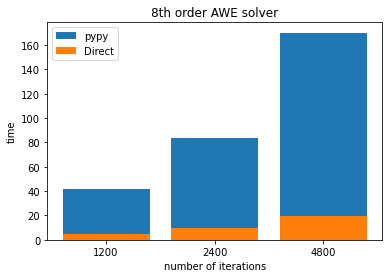

In [6]:
plt.bar(x[1:], JSten, label='pypy')
plt.bar(x[1:], direct, label="Direct", tick_label=iters)

plt.legend()
plt.title('8th order AWE solver')
plt.ylabel("time")
plt.xlabel('number of iterations')
plt.show()